# 特徴量分析用スクリプト
featureimportanceとか
相関行列とか

In [47]:
import numpy as np
import gensim
import requests
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic
import pandas as pd
from wikipedia2vec import Wikipedia2Vec
import pickle
import matplotlib.pyplot as plt

In [62]:
#dataのインポート+シャッフル
data = pd.read_csv("./dataset/exp_data.csv",index_col = 0).sample(frac=1, random_state=3).reset_index(drop=True)

In [63]:
#カラム配列定義
#特徴量カラム

fature_columns =  ["sim_by_mcg","is_a_by_mcg","lexvec_sim","wiki2vec_sim","wn_hu_average",
                "wn_pu_average","wn_sim_path","wn_sim_wup",
                "is_include_word","bert_sim","lexvec_diff","wiki2vec_diff","bert_diff"]
"""

fature_columns =  ["sim_by_mcg","is_a_by_mcg","wiki2vec_sim","wn_hu_average",
                "wn_pu_average","wn_sim_path","wn_sim_wup",
                "is_include_word","bert_sim","lexvec_diff","wiki2vec_diff","bert_diff"]
"""

#通常の特徴量ラベル
X_normal_columns = ["sim_by_mcg","is_a_by_mcg","lexvec_sim","wiki2vec_sim","wn_hu_average",
                "wn_pu_average","wn_sim_path","wn_sim_wup","is_include_word","bert_sim"]
"""
X_normal_columns = ["sim_by_mcg","is_a_by_mcg","wiki2vec_sim","wn_hu_average",
                "wn_pu_average","wn_sim_path","wn_sim_wup","is_include_word","bert_sim"]
"""
#ベクトル系特徴量ラベル
pca_di={"lexvec_diff":1,"wiki2vec_diff":1,"bert_diff":1}

#被験者実験データ
ans_columns = [ 'ans_ueda',
       'ans_daisuke', 'ans_kazuma', 'ans_sugi']

In [64]:
# 欠損値は最頻値補完を行う
def fill_na_mean(data):
    data.loc[:,"sim_by_mcg"] = data.loc[:,"sim_by_mcg"].fillna(data.loc[:,"sim_by_mcg"].mode()[0])
    data.loc[:,"is_a_by_mcg"] = data.loc[:,"is_a_by_mcg"].fillna(data.loc[:,"is_a_by_mcg"].mode()[0])
    data.loc[:,"wiki2vec_sim"] = data.loc[:,"wiki2vec_sim"].fillna(data.loc[:,"wiki2vec_sim"].mode()[0])
    data.loc[:,"wiki2vec_diff"] = data.loc[:,"wiki2vec_diff"].fillna(data.loc[:,"wiki2vec_diff"].mode()[0])
    return data
data = fill_na_mean(data)
#クラスラベルエンコーディング
from sklearn.preprocessing import LabelEncoder
def label_encorder(data):
    le = LabelEncoder()
    encoded = le.fit_transform(data['relation'].values)
    for ans_c in ans_columns:
        temp_label = le.transform(data[ans_c].values)
        data[ans_c] = temp_label
    data.loc[:,'relation_label'] = encoded
    print(str(data["relation"].unique())+","+str(le.transform(data["relation"].unique())))
    return data
data = label_encorder(data)
data.head()

['h1' 'k' 'h2' 's1' 's2'],[0 2 1 3 4]


,class_a,class_b,relation,ans_yamasaki,ans_ueda,ans_daisuke,ans_hosomi,ans_kazuma,ans_sugi,type,...,wn_sim_res,wn_sim_jcn,wn_sim_lin,has_same_word,is_include_word,bert_sim,lexvec_diff,wiki2vec_diff,bert_diff,relation_label
0,bar_block,block,h1,s1,0,0,h1,1,0,program,...,4.353092,5.000000e+299,0.666013,1.0,0.0,0.987286,"[0.023808, -0.0634425, -0.082867995, -0.011244...","[0.06487777, 0.1621111, 0.24762037, -0.0489930...","[-0.18368639, -0.15567335, -0.015512198, -0.07...",0
1,doctor,person,h1,k,0,0,h1,3,0,sample,...,2.333545,1.748681e-01,0.449377,0.0,0.0,0.961607,"[-0.134891, 0.079426005, 0.039936, -0.014531, ...","[0.2795563, 0.19265658, -0.08967748, 0.2729026...","[-0.036303345, 0.026970536, 0.079046816, -0.03...",0
2,task_system,task,k,h1,3,2,h1,0,4,analyse,...,3.124216,5.000000e+299,0.500000,1.0,0.0,1.000000,"[0.017359499, 0.022408992, -0.1071575, -0.0707...","[0.0048446953, 0.19927415, -0.19898042, -0.104...","[0.992626, 0.7901973, -0.76960677, 0.76129097,...",2
3,user,administrator,h2,k,0,0,s1,1,0,analyse,...,2.333545,9.831757e-02,0.314532,0.0,0.0,0.946332,"[-0.13642, -0.085788, 0.13085201, 0.016377002,...","[-0.4439574, -0.30559474, -0.25761124, 0.15385...","[-0.1094939, -0.04155261, -0.2646673, -0.14161...",1
4,schedule,schedule_flight,k,h2,1,2,NaN,1,1,analyse,...,5.518239,5.000000e+299,0.530687,1.0,1.0,0.999963,"[-0.086802, 0.124642, -0.007966995, 0.1174265,...","[0.28168777, -0.14062633, 0.10214912, 0.479167...","[-0.38849694, -0.60766906, 0.6211178, -0.33773...",2


In [65]:
#特徴量の選別 wn_sim_jcnは値がバグっているので使わない(infinityが入っている)
X_data = data.loc[:,fature_columns]
# yの定義
y = data.loc[:,"relation_label"].values.astype("int32")

In [66]:
#学習用メソッド
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#str_arrをarrに変換
def convert_to_arr(vec_str):
    vec_arr = None
    for s in vec_str:
        if vec_arr is None:
            vec_arr =np.array(s[1:-1].split(", ")).astype("float32")
        else:
            vec_arr = np.block([[vec_arr],[np.array(s[1:-1].split(", ")).astype("float32")]])
    return vec_arr
#diffラベルのpca_ssモデル trainとtest arrを返す
def ss_pca(train,pca_n):
    scaler = StandardScaler()
    train=scaler.fit_transform(train)
    pca = PCA(n_components = pca_n)
    train = pca.fit_transform(train)
    return train

In [67]:
#通常系の特徴量と、vec系の特徴量に分割し、vecにはpcaを行って最後に結合する
X = X_data.loc[:,X_normal_columns].values.astype("float64").astype("float64")
for c_name, n in pca_di.items():
    vec_arr = convert_to_arr(X_data.loc[:,c_name])
    pca_arr = ss_pca(vec_arr,n)
    X = np.concatenate([X, pca_arr], 1)
    

In [68]:
X.shape

(425, 13)

In [69]:
#普通に学習を行う
#XGBOOST
model = xgb.XGBClassifier(n_estimators=1500,max_depth=25,learning_rate=0.01)
model.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=25,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1500, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [70]:
import matplotlib.pyplot as plt

features = X_normal_columns
for name, n in pca_di.items():
    features.extend([name+str(i) for i in range(n)])
    
mapper = {'f{0}'.format(i): v for i, v in enumerate(features)}
mapped = {mapper[k]: v for k, v in model._Booster.get_fscore().items()}
imp_tapple = sorted(mapped.items(),key=lambda x:x[1])




<BarContainer object of 13 artists>

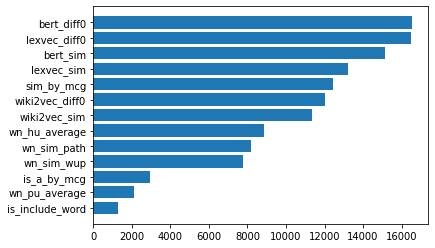

In [71]:
label = [ t[0] for t in imp_tapple]
height = [t[1] for t in imp_tapple]
plt.barh(np.arange(0,len(label)), height, tick_label=label, align="center")